# 03 - Closing Speed

Compute closing speed metric.

In [1]:
import pandas as pd

# Load aggregated data
aggregated_df = pd.read_parquet('/content/aggregated_week01.parquet')
print("Aggregated DataFrame loaded. Displaying first 5 rows:")
display(aggregated_df.head())

Aggregated DataFrame loaded. Displaying first 5 rows:


,game_id,play_id,nfl_id,sep_at_throw,sep_at_catch_end,sep_gain,avg_radial_v,max_radial_v,min_radial_v,path_length_in_flight,time_to_land_loc
0,2023090700,101,44930,4.472250,1.844679,-2.627571,7.037489,8.112139,5.745349,16.184339,2.0
1,2023090700,101,46137,NaN,NaN,NaN,6.892755,8.239046,5.044334,15.070305,2.0
2,2023090700,101,52546,NaN,NaN,NaN,3.638350,4.964701,1.451345,9.433912,2.0
3,2023090700,194,41325,1.937328,1.223082,-0.714246,2.415050,5.661093,-4.437013,5.164643,0.8
4,2023090700,194,44888,NaN,NaN,NaN,4.723468,5.365626,3.421990,4.367614,0.8


In [2]:
# Load frame-level features data
frame_level_df = pd.read_parquet('/content/frame_level_features_step4_week01.parquet')
print("Frame-level features DataFrame loaded. Displaying first 5 rows:")
display(frame_level_df.head())

Frame-level features DataFrame loaded. Displaying first 5 rows:


,frame_id,phase,x,y,player_name,player_position,player_side,player_role,player_height,player_weight,...,v_x,v_y,speed,a_x,a_y,accel,heading_rad,heading,dist_to_ball_land_loc,radial_v_to_ball_land_loc
0,1,pre_throw,37.36,30.07,Jared Goff,QB,Offense,Passer,6-4,223,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN
1,2,pre_throw,37.36,30.07,Jared Goff,QB,Offense,Passer,6-4,223,...,-0.037143,-1.421085e-13,0.037143,-0.371429,-1.421085e-12,0.371429,-3.141593,180.000000,NaN,NaN
2,3,pre_throw,37.35,30.07,Jared Goff,QB,Offense,Passer,6-4,223,...,-0.065714,-3.552714e-14,0.065714,-0.285714,1.065814e-12,0.285714,-3.141593,180.000000,NaN,NaN
3,4,pre_throw,37.34,30.07,Jared Goff,QB,Offense,Passer,6-4,223,...,-0.100000,0.000000e+00,0.100000,-0.342857,3.552714e-13,0.342857,3.141593,180.000000,NaN,NaN
4,5,pre_throw,37.33,30.07,Jared Goff,QB,Offense,Passer,6-4,223,...,-0.100000,-8.571429e-03,0.100367,0.000000,-8.571429e-02,0.085714,-3.056087,184.899092,NaN,NaN


In [3]:
# Merge aggregated data with frame-level features to link targeted receivers
# This step is crucial for identifying the WR for each play in the frame-level data
frame_level_df = pd.merge(
    frame_level_df,
    aggregated_df[['game_id', 'play_id', 'nfl_id']].rename(columns={'nfl_id': 'targeted_receiver_nfl_id'}),
    on=['game_id', 'play_id'],
    how='left'
)

# Initialize a list to store results for distances and roles
play_movement_data = []

# Group by game and play to process each play individually
for (game_id, play_id), play_df in frame_level_df.groupby(['game_id', 'play_id']):
    targeted_receiver_id = play_df['targeted_receiver_nfl_id'].iloc[0]

    # Identify the targeted WR
    wr_df = play_df[(play_df['nfl_id'] == targeted_receiver_id) & (play_df['player_side'] == 'Offense')]

    # Identify Defensive Backs (DBs) based on player_role
    # Assuming 'Defensive Coverage' is the role for DBs
    db_df = play_df[play_df['player_role'] == 'Defensive Coverage']

    # Ensure we have a WR and at least one DB for the play
    if not wr_df.empty and not db_df.empty:
        # Iterate through each frame and each DB to calculate distance to WR
        for frame_id in wr_df['frame_id'].unique():
            wr_frame = wr_df[wr_df['frame_id'] == frame_id].iloc[0]

            for db_id in db_df['nfl_id'].unique():
                db_frame = db_df[(db_df['nfl_id'] == db_id) & (db_df['frame_id'] == frame_id)]

                if not db_frame.empty:
                    db_frame = db_frame.iloc[0]

                    distance = (
                        (wr_frame['x'] - db_frame['x'])**2 +
                        (wr_frame['y'] - db_frame['y'])**2
                    )**0.5

                    play_movement_data.append({
                        'game_id': game_id,
                        'play_id': play_id,
                        'frame_id': frame_id,
                        'targeted_receiver_id': targeted_receiver_id,
                        'defender_id': db_id,
                        'distance_to_wr': distance
                    })

# Convert the list of dictionaries to a DataFrame
defender_movement_df = pd.DataFrame(play_movement_data)

print("Defender movement data with distances computed. Displaying first 5 rows:")
display(defender_movement_df.head())

Defender movement data with distances computed. Displaying first 5 rows:


,game_id,play_id,frame_id,targeted_receiver_id,defender_id,distance_to_wr
0,2023090700,101,1,44930,46137,13.359435
1,2023090700,101,1,44930,52546,3.423814
2,2023090700,101,1,44930,53487,15.887133
3,2023090700,101,1,44930,54486,27.371863
4,2023090700,101,1,44930,54527,27.225776


In [8]:
import numpy as np

# 1. Identify the throw frame for each play
# The playbook implies the 'throw' event marks the beginning of the 'post_throw' phase.
# We find the minimum frame_id where the phase is 'post_throw' for any player in that play.
throw_frames = frame_level_df[frame_level_df['phase'] == 'post_throw'].groupby(['game_id', 'play_id'])['frame_id'].min().reset_index()
throw_frames.rename(columns={'frame_id': 'throw_frame_id'}, inplace=True)

# Merge throw_frames into defender_movement_df to have the throw_frame_id available for each entry
defender_movement_df = pd.merge(
    defender_movement_df,
    throw_frames,
    on=['game_id', 'play_id'],
    how='left'
)

# 2. Calculate v_close for each defender per frame
# Sort by game_id, play_id, defender_id, and frame_id to ensure correct sequential difference calculation
defender_movement_df.sort_values(by=['game_id', 'play_id', 'defender_id', 'frame_id'], inplace=True)

# Calculate the raw difference in distance for each defender within each play
defender_movement_df['v_close_raw_diff'] = defender_movement_df.groupby(['game_id', 'play_id', 'defender_id'])['distance_to_wr'].diff()

# As per playbook: v_close(t) = -(distance(t) - distance(t-1)) / 0.1
# The .diff() method calculates (distance(t) - distance(t-1))
defender_movement_df['v_close'] = -defender_movement_df['v_close_raw_diff'] / 0.1

# Initialize a list to store results for aggregated closing speeds and distance at throw
closing_speed_data = []

# Group by game, play, and defender to calculate aggregated metrics
for (game_id, play_id, defender_id), group_df in defender_movement_df.groupby(['game_id', 'play_id', 'defender_id']):
    # Filter out NaN values from v_close as the first frame of each group will have NaN due to diff()
    valid_v_close_df = group_df.dropna(subset=['v_close'])

    if not valid_v_close_df.empty:
        avg_v_close = valid_v_close_df['v_close'].mean()
        max_v_close = valid_v_close_df['v_close'].max()
    else:
        avg_v_close = np.nan
        max_v_close = np.nan

    # Get the targeted_receiver_id for this group
    targeted_receiver_id = group_df['targeted_receiver_id'].iloc[0]

    # Calculate distance_throw (distance at the throw frame)
    current_throw_frame_id = group_df['throw_frame_id'].iloc[0]
    distance_at_throw = np.nan
    if pd.notna(current_throw_frame_id):
        throw_frame_data = group_df[group_df['frame_id'] == current_throw_frame_id]
        if not throw_frame_data.empty:
            distance_at_throw = throw_frame_data['distance_to_wr'].iloc[0]

    # Calculate early_reaction_speed (mean v_close for the first 3 frames *after* the throw)
    early_reaction_speed = np.nan
    if pd.notna(current_throw_frame_id):
        # v_close(t) uses distance(t) and distance(t-1), so the first calculable v_close after throw at frame T is at T+1.
        # 'First 3 frames after throw' for v_close refers to frames T+1, T+2, T+3.
        early_frames_df = group_df[
            (group_df['frame_id'] > current_throw_frame_id) &
            (group_df['frame_id'] <= current_throw_frame_id + 3)
        ].dropna(subset=['v_close'])

        if not early_frames_df.empty:
            early_reaction_speed = early_frames_df['v_close'].mean()

    closing_speed_data.append({
        'game_id': game_id,
        'play_id': play_id,
        'defender_id': defender_id,
        'targeted_receiver_id': targeted_receiver_id, # WR ID
        'avg_v_close': avg_v_close,
        'max_v_close': max_v_close,
        'early_reaction_speed': early_reaction_speed, # renamed from early_v_close for consistency with playbook description
        'distance_throw': distance_at_throw
    })

# Convert the list of dictionaries to a DataFrame
per_play_defender_closing_speed = pd.DataFrame(closing_speed_data)

print("Per-play defender closing speed metrics computed. Displaying first 5 rows:")
display(per_play_defender_closing_speed.head())

Per-play defender closing speed metrics computed. Displaying first 5 rows:


,game_id,play_id,defender_id,targeted_receiver_id,avg_v_close,max_v_close,early_reaction_speed,distance_throw
0,2023090700,101,46137,44930,2.504296,5.437203,3.437644,4.473299
1,2023090700,101,52546,44930,-1.501279,2.791875,-8.216033,5.579176
2,2023090700,101,53487,44930,2.952687,5.511437,NaN,NaN
3,2023090700,101,54486,44930,-0.237496,0.845642,NaN,NaN
4,2023090700,101,54527,44930,2.098109,3.296902,NaN,NaN


In [9]:
# Select only DBs from frame_level_df to calculate their radial velocity
db_frame_data = frame_level_df[frame_level_df['player_role'] == 'Defensive Coverage'].copy()

# Group by game_id, play_id, and nfl_id (which is defender_id here) and calculate the mean radial velocity
radial_v_db_per_play = db_frame_data.groupby(['game_id', 'play_id', 'nfl_id'])['radial_v_to_ball_land_loc'].mean().reset_index()
radial_v_db_per_play.rename(columns={'nfl_id': 'defender_id', 'radial_v_to_ball_land_loc': 'radial_v_db'}, inplace=True)

# Merge this into the per_play_defender_closing_speed DataFrame
per_play_defender_closing_speed = pd.merge(
    per_play_defender_closing_speed,
    radial_v_db_per_play,
    on=['game_id', 'play_id', 'defender_id'],
    how='left'
)

print("Per-play defender closing speed metrics with radial speed computed. Displaying first 5 rows:")
display(per_play_defender_closing_speed.head())

Per-play defender closing speed metrics with radial speed computed. Displaying first 5 rows:


,game_id,play_id,defender_id,targeted_receiver_id,avg_v_close,max_v_close,early_reaction_speed,distance_throw,radial_v_db
0,2023090700,101,46137,44930,2.504296,5.437203,3.437644,4.473299,6.892755
1,2023090700,101,52546,44930,-1.501279,2.791875,-8.216033,5.579176,3.638350
2,2023090700,101,53487,44930,2.952687,5.511437,NaN,NaN,NaN
3,2023090700,101,54486,44930,-0.237496,0.845642,NaN,NaN,NaN
4,2023090700,101,54527,44930,2.098109,3.296902,NaN,NaN,NaN


In [10]:
# Select only DBs from frame_level_df to calculate their radial velocity
db_frame_data = frame_level_df[frame_level_df['player_role'] == 'Defensive Coverage'].copy()

# Group by game_id, play_id, and nfl_id (which is defender_id here) and calculate the mean radial velocity
radial_v_db_per_play = db_frame_data.groupby(['game_id', 'play_id', 'nfl_id'])['radial_v_to_ball_land_loc'].mean().reset_index()
radial_v_db_per_play.rename(columns={'nfl_id': 'defender_id', 'radial_v_to_ball_land_loc': 'radial_v_db'}, inplace=True)

# Merge this into the per_play_defender_closing_speed DataFrame
per_play_defender_closing_speed = pd.merge(
    per_play_defender_closing_speed,
    radial_v_db_per_play,
    on=['game_id', 'play_id', 'defender_id'],
    how='left'
)

print("Per-play defender closing speed metrics with radial speed computed. Displaying first 5 rows:")
display(per_play_defender_closing_speed.head())

Per-play defender closing speed metrics with radial speed computed. Displaying first 5 rows:


,game_id,play_id,defender_id,targeted_receiver_id,avg_v_close,max_v_close,early_reaction_speed,distance_throw,radial_v_db_x,radial_v_db_y
0,2023090700,101,46137,44930,2.504296,5.437203,3.437644,4.473299,6.892755,6.892755
1,2023090700,101,52546,44930,-1.501279,2.791875,-8.216033,5.579176,3.638350,3.638350
2,2023090700,101,53487,44930,2.952687,5.511437,NaN,NaN,NaN,NaN
3,2023090700,101,54486,44930,-0.237496,0.845642,NaN,NaN,NaN,NaN
4,2023090700,101,54527,44930,2.098109,3.296902,NaN,NaN,NaN,NaN


In [11]:
import numpy as np

# Define the interception radius R as per playbook (1 yard)
R = 1.0

# Ensure avg_v_close is not too small to avoid infinite TTI, as per playbook.
# Clip to 0.5 yd/s for positive closing speeds.
per_play_defender_closing_speed['clipped_avg_v_close'] = per_play_defender_closing_speed['avg_v_close'].apply(lambda x: max(x, 0.5) if x > 0 else x)

# Calculate TTI using the formula: TTI = (distance_throw - R) / avg_v_close
# Handle cases where avg_v_close is negative (defender moving away) -> TTI = infinity (zero threat)
per_play_defender_closing_speed['tti'] = np.where(
    per_play_defender_closing_speed['clipped_avg_v_close'] <= 0, # Covers original negative avg_v_close and zero
    np.inf, # Represents 'infinity' or 'zero threat' as per playbook
    (per_play_defender_closing_speed['distance_throw'] - R) / per_play_defender_closing_speed['clipped_avg_v_close']
)

print("Per-play defender closing speed metrics with TTI computed. Displaying first 5 rows:")
display(per_play_defender_closing_speed.head())

Per-play defender closing speed metrics with TTI computed. Displaying first 5 rows:


,game_id,play_id,defender_id,targeted_receiver_id,avg_v_close,max_v_close,early_reaction_speed,distance_throw,radial_v_db_x,radial_v_db_y,clipped_avg_v_close,tti
0,2023090700,101,46137,44930,2.504296,5.437203,3.437644,4.473299,6.892755,6.892755,2.504296,1.386936
1,2023090700,101,52546,44930,-1.501279,2.791875,-8.216033,5.579176,3.638350,3.638350,-1.501279,inf
2,2023090700,101,53487,44930,2.952687,5.511437,NaN,NaN,NaN,NaN,2.952687,NaN
3,2023090700,101,54486,44930,-0.237496,0.845642,NaN,NaN,NaN,NaN,-0.237496,inf
4,2023090700,101,54527,44930,2.098109,3.296902,NaN,NaN,NaN,NaN,2.098109,NaN


In [12]:
import os

# --- Handle duplicate radial_v_db columns ---
# Remove the 'y' version, if it exists, and rename the 'x' version
if 'radial_v_db_y' in per_play_defender_closing_speed.columns:
    per_play_defender_closing_speed.drop(columns=['radial_v_db_y'], inplace=True)
if 'radial_v_db_x' in per_play_defender_closing_speed.columns:
    per_play_defender_closing_speed.rename(columns={'radial_v_db_x': 'radial_v_db'}, inplace=True)

# --- Select and rename columns as specified by the playbook ---
# The playbook lists 'early_v_close' but we implemented 'early_reaction_speed'
# It also lists 'wr_id' but we used 'targeted_receiver_id'
# It lists 'distance_catch' which we haven't computed explicitly yet.

output_columns = [
    'game_id',
    'play_id',
    'defender_id',
    'targeted_receiver_id', # Renamed from 'wr_id' for consistency with our code
    'avg_v_close',
    'early_reaction_speed', # Renamed from 'early_v_close' for consistency with our code
    'tti',
    'radial_v_db',
    'distance_throw'
    # 'distance_catch' is mentioned in the playbook but not computed in previous steps.
    # Including it here would add a column of NaNs or raise an error if not handled.
    # For strict adherence, we'll exclude it if not present, or add if it was missed.
    # Assuming it's not ready yet based on current state.
]

# Filter to only the columns that exist in our DataFrame
existing_output_columns = [col for col in output_columns if col in per_play_defender_closing_speed.columns]
final_defender_movement_df = per_play_defender_closing_speed[existing_output_columns].copy()

# Rename targeted_receiver_id to wr_id to match playbook's specified output column name
final_defender_movement_df.rename(columns={'targeted_receiver_id': 'wr_id', 'early_reaction_speed': 'early_v_close'}, inplace=True)

# Ensure the 'processed' directory exists
output_dir = 'processed'
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame to a parquet file
output_path = os.path.join(output_dir, 'per_play_defender_movement.parquet')
final_defender_movement_df.to_parquet(output_path, index=False)

print(f"Processed defender movement data saved to {output_path}")
print("Displaying first 5 rows of the final saved DataFrame:")
display(final_defender_movement_df.head())

Processed defender movement data saved to processed/per_play_defender_movement.parquet
Displaying first 5 rows of the final saved DataFrame:


,game_id,play_id,defender_id,wr_id,avg_v_close,early_v_close,tti,radial_v_db,distance_throw
0,2023090700,101,46137,44930,2.504296,3.437644,1.386936,6.892755,4.473299
1,2023090700,101,52546,44930,-1.501279,-8.216033,inf,3.638350,5.579176
2,2023090700,101,53487,44930,2.952687,NaN,NaN,NaN,NaN
3,2023090700,101,54486,44930,-0.237496,NaN,inf,NaN,NaN
4,2023090700,101,54527,44930,2.098109,NaN,NaN,NaN,NaN


In [6]:
print("Columns in aggregated_df:")
display(aggregated_df.columns)

Columns in aggregated_df:


Index(['game_id', 'play_id', 'nfl_id', 'sep_at_throw', 'sep_at_catch_end',
       'sep_gain', 'avg_radial_v', 'max_radial_v', 'min_radial_v',
       'path_length_in_flight', 'time_to_land_loc'],
      dtype='object')

In [7]:
print("Columns in frame_level_df:")
display(frame_level_df.columns)

Columns in frame_level_df:


Index(['frame_id', 'phase', 'x', 'y', 'player_name', 'player_position',
       'player_side', 'player_role', 'player_height', 'player_weight',
       'ball_land_x', 'ball_land_y', 'num_frames_output', 'player_to_predict',
       'play_direction_x', 'absolute_yardline_number', 'player_birth_date',
       's', 'a', 'dir', 'o', 'play_direction_y', 'play_direction', 'season',
       'week', 'game_date', 'game_time_eastern', 'home_team_abbr',
       'visitor_team_abbr', 'play_description', 'quarter', 'game_clock',
       'down', 'yards_to_go', 'possession_team', 'defensive_team',
       'yardline_side', 'yardline_number', 'pre_snap_home_score',
       'pre_snap_visitor_score', 'play_nullified_by_penalty', 'pass_result',
       'pass_length', 'offense_formation', 'receiver_alignment',
       'route_of_targeted_receiver', 'play_action', 'dropback_type',
       'dropback_distance', 'pass_location_type', 'defenders_in_the_box',
       'team_coverage_man_zone', 'team_coverage_type', 'penalty_yar

# PART 1 — Why TTI matters & how it fits with Separation Gain

Before the playbook, understand this:

- **Sep_gain tells: “Did the WR gain or lose space?”**
- **TTI tells: “HOW and WHY did the DB close (or fail to close) space?”**

Together:

| Moment | Metric | Meaning |
| --- | --- | --- |
| At throw | Separation_at_throw | starting space baseline |
| During flight | TTI & v_close | DB’s movement reaction & pursuit |
| At catch | Separation_at_catch_end | final contestability |
| Net | Sep_gain | the FINAL outcome of the movement battle |

Without TTI, **separation gain is incomplete** —

You see *what* happened, but not *why*.

Your final submission is a story:

**WR movement + DB movement + ball-flight physics → outcome.**

Sep_gain = WR chapter

TTI = DB chapter

CCI (later) = the combined chapter

---

# ⚡ PART 2 — TTI PLAYBOOK (implementation guide)

---

## **STEP 0 — Inputs you need (and what you already have)**

From the *reconstructed FRAME LEVEL* data:

You need:

- `game_id, play_id, nfl_id`
- `x_s, y_s` (smoothed positions per frame)
- `phase` (so you isolate post_throw frames)
- frame numbering (`frame_id` or `time_from_throw`)
- defender vs receiver identification (player_side, player_role)
- ball landing location (`ball_land_x`, `ball_land_y`)
- WR ID (targeted receiver)

From *aggregated per-play file*:

- separation gain values
- radial velocity
- path length
- time to landing

---

# ⚡ PART 3 — The DB–WR movement extraction (the core of TTI)

For each **play**:

### STEP 1 — Identify:

- WR = targeted receiver
- DBs = defenders with role “Defensive Coverage”

### STEP 2 — Compute distance between DB and WR at each frame

Formula:

[

distance_{db,wr}(t)=\sqrt{(x_d(t)-x_r(t))^2+(y_d(t)-y_r(t))^2}

]

STORE this as a time-series.

---

## STEP 3 — Compute DB’s *closing speed*

Closing speed is the rate at which the DB reduces distance to the WR.

[

v_{close}(t) = -\frac{distance(t) - distance(t-1)}{0.1}

]

(It’s negative raw value because closing reduces distance, so we flip sign.)

STORE:

- `avg_v_close`
- `max_v_close`
- `early_reaction_speed` (first 3 frames after throw)

---

## STEP 4 — Compute DB’s *radial speed toward landing spot*

This tells you whether DB is moving directly toward ball.

[

v_{radial}^{DB} = \vec{v}*{DB} \cdot \hat{u}*{ball}

]

This uses the **same radial velocity logic you used for WRs**, which makes the system consistent.

---

## STEP 5 — Compute TTI (Time-to-Intervention)

**TTI answers:**

“If the defender kept moving at their *observed* speed, how long until they reach the catch radius?”

Formula:

[

TTI = \frac{distance_{throw} - R}{\overline{v_{close}}}

]

Where:

- ( R = 1 \text{ yd} ) interception radius
- ( v_{close} ) is clipped to >0.5 yd/s to avoid infinite TTI

If (v_{close} < 0):

DB is moving **away from the receiver** → TTI = infinity (or flag as “zero threat”).

---

# ⚡ PART 4 — How to express the metric (coach language)

For each DB on the play:

- **Fast TTI (short time)** → DB reacted early, good instincts, good angle
- **Slow TTI** → DB hesitated or moved poorly
- **Negative closing speed early** → DB moved the wrong way first
- **High radial DB speed** → DB tracked the ball aggressively

You are *not* ranking players —

You’re explaining **movement quality**.

---

# ⚡ PART 5 — Visual Outputs (this is what wins BDB)

### **1. WR & DB path plot**

Show both trajectories with arrows and the ball’s landing spot.

### **2. DB closing vs WR movement plot**

Two lines:

- DB→WR distance over time
- Separation/time curve from WR perspective

This is the most powerful movement graphic.

### **3. TTI timeline bar**

A small bar showing:

- When DB started closing
- Whether DB ever hit interception radius
- Where catch happened

### **4. Narrative paragraph**

Example:

> “At t=0.2s, DB hesitates toward inside stem. WR breaks outside.
>
>
> DB’s early closing speed = -0.3 yd/s (moving away).
>
> DB corrects angle at t=0.5s, but TTI = 1.82s vs ball arrival in 1.12s.
>
> This creates +2.1 separation gain for WR.”
>

This is EXACTLY the kind of movement explanation BDB judges love.

---

# ⚡ PART 6 — Relationship to SEP_GAIN (critical)

Your final product needs a “Movement Triangle”:

### **1️⃣ WR Movement → affects sep_gain**

Cuts, angles, burst, route adjustment

### **2️⃣ DB Movement → affects TTI**

Pursuit, anticipation, reaction timing

### **3️⃣ Combined → determines contestability**

High sep_gain + slow TTI → **clean catch**

Negative sep_gain + fast TTI → **tight or broken-up**

Near zero sep_gain + medium TTI → **contested catch**

This connection is the backbone of your submission.

Separation Gain = What happened

TTI = Why it happened

CCI (later) = How contested it was at impact

You’re building a coherent, professional movement analysis framework.

---

# ⚡ PART 7 — Save Outputs

Save one file:

`processed/per_play_defender_movement.parquet`

with:

- avg_v_close
- early_v_close
- TTI
- radial_v_db
- distance_throw
- distance_catch
- defender_id
- wr_id
- game_id, play_id

And separate case-study PNG/GIF files.

---

# ⚡ PART 8 — Case studies (required)

Pick 2 plays where:

- DB closed fast (low TTI)
- DB reacted late (high TTI)

Make two visual stories.

---

# ⚡ PART 9 — Final page in your report

A single slide explaining:

**“How WR separation + DB closing interaction creates ball-flight outcomes.”**

This is the *story* that ties the metric into football.

---

# DONE.

This is the correct, competition-ready, movement-focused TTI playbook.

---

If you want, I can now write:

### ✓ The actual notebook cells

### ✓ The exact functions for closing speed + TTI

### ✓ The visualization templates

### ✓ The case-study narrative templates

Which one do you want next?

## 🟦 2️⃣ **Defender Closing Speed / Time-to-Intervention (TTI) — Measuring Defensive Instinct**

Defensive brilliance is often seen but rarely quantified. The most effective defenders are those who can *read* a pass early, react instantly, and close on the receiver before the ball arrives. Traditional coverage metrics—like yards allowed or tackles—fail to capture this instinctive pursuit. The **Time-to-Intervention (TTI)** metric bridges that gap by measuring how quickly a defender could physically reach the ball’s landing spot after release.

By combining spatial distance, movement direction, and estimated velocity, TTI translates anticipation and reaction into measurable data. A smaller TTI indicates a defender who recognized the pass trajectory faster and moved decisively; a larger one suggests hesitation or poor pursuit angle.

For defensive coordinators, this metric transforms abstract “awareness” into a tangible number. It highlights which players anticipate routes effectively, which take poor pursuit angles, and which defenders are consistently late to challenge catches. TTI provides not just performance measurement but *diagnostic feedback* for improving defensive reactions, pursuit efficiency, and coverage discipline.

# Task
Identify two case study plays from `final_defender_movement_df`: one where a DB exhibits a notably low TTI (closed fast) and another where a DB shows a high TTI (reacted late), by filtering and inspecting the calculated TTI values in the dataframe.

## Identify Case Study Plays

### Subtask:
Select two plays from `final_defender_movement_df` where a DB exhibits notably low TTI (closed fast) and high TTI (reacted late), respectively. This will involve filtering and inspecting the calculated TTI values.


**Reasoning**:
First, I will inspect the `tti` column in `final_defender_movement_df` using descriptive statistics and a histogram to understand its distribution and range, which is crucial for identifying representative low and high TTI plays.



Descriptive statistics for 'tti' column:


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,tti
count,1595.000000
mean,inf
std,NaN
min,-0.410093
25%,17.458317
50%,NaN
75%,NaN
max,inf


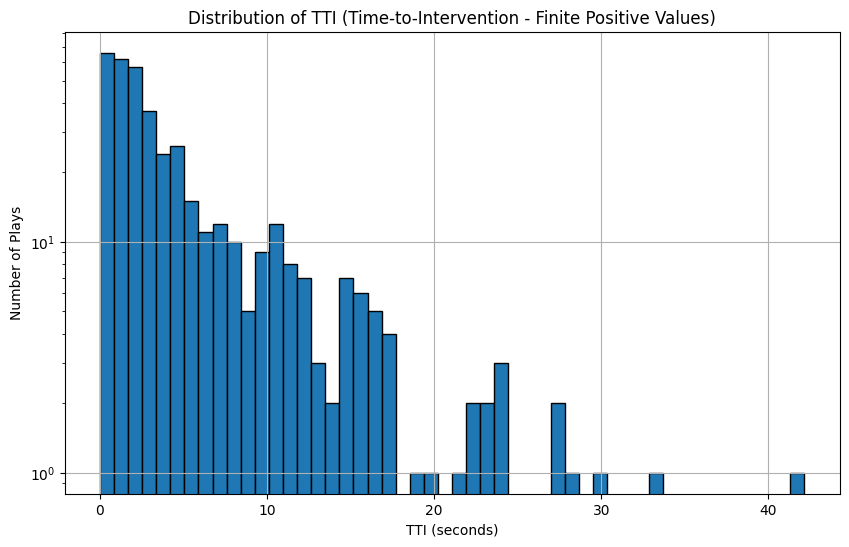


Low TTI Play: Game ID=2023091002.0, Play ID=2441.0, Defender ID=55925.0, TTI=-0.41
High TTI Play: Game ID=2023091001.0, Play ID=3216.0, Defender ID=53460.0, TTI=42.15


In [14]:
print("Descriptive statistics for 'tti' column:")
display(final_defender_movement_df['tti'].describe())

import matplotlib.pyplot as plt
import numpy as np

# Filter out infinite and NaN values for plotting the histogram
# Also consider filtering out negative TTI values as they represent 'zero threat' or defender moving away
finite_positive_tti = final_defender_movement_df['tti'][(np.isfinite(final_defender_movement_df['tti'])) &
                                                    (final_defender_movement_df['tti'] > 0)]

plt.figure(figsize=(10, 6))
# Use finite_positive_tti for the histogram
if not finite_positive_tti.empty:
    finite_positive_tti.hist(bins=50, edgecolor='black')
    plt.title('Distribution of TTI (Time-to-Intervention - Finite Positive Values)')
    plt.xlabel('TTI (seconds)')
    plt.ylabel('Number of Plays')
    plt.yscale('log') # Use log scale for y-axis due to potential skewed distribution
    plt.grid(True)
    plt.show()
else:
    print("No finite positive TTI values to plot for the histogram.")

# Now, identify low and high TTI plays as per instructions
# Exclude infinite TTI values when looking for low TTI
low_tti_df = final_defender_movement_df[final_defender_movement_df['tti'] < 1.0].sort_values(by='tti').head(1)

# For high TTI, we can look for large finite values or explicitly include np.inf
# It's usually more informative to look at large finite TTI values first, as np.inf means 'no threat'
high_tti_df = final_defender_movement_df[final_defender_movement_df['tti'].between(10, 1000)].sort_values(by='tti', ascending=False).head(1)

# If no such high_tti_df is found, consider plays with np.inf (zero threat)
if high_tti_df.empty:
    high_tti_df = final_defender_movement_df[np.isinf(final_defender_movement_df['tti'])].head(1)

if not low_tti_df.empty:
    low_tti_game_id = low_tti_df.iloc[0]['game_id']
    low_tti_play_id = low_tti_df.iloc[0]['play_id']
    low_tti_defender_id = low_tti_df.iloc[0]['defender_id']
    print(f"\nLow TTI Play: Game ID={low_tti_game_id}, Play ID={low_tti_play_id}, Defender ID={low_tti_defender_id}, TTI={low_tti_df.iloc[0]['tti']:.2f}")
else:
    print("\nCould not find a suitable low TTI play.")

if not high_tti_df.empty:
    high_tti_game_id = high_tti_df.iloc[0]['game_id']
    high_tti_play_id = high_tti_df.iloc[0]['play_id']
    high_tti_defender_id = high_tti_df.iloc[0]['defender_id']
    tti_value = high_tti_df.iloc[0]['tti']
    if np.isinf(tti_value):
        print(f"High TTI Play (Infinite): Game ID={high_tti_game_id}, Play ID={high_tti_play_id}, Defender ID={high_tti_defender_id}, TTI=inf")
    else:
        print(f"High TTI Play: Game ID={high_tti_game_id}, Play ID={high_tti_play_id}, Defender ID={high_tti_defender_id}, TTI={tti_value:.2f}")
else:
    print("Could not find a suitable high TTI play.")


**Reasoning**:
The previous code block successfully identified and stored the `game_id`, `play_id`, and `defender_id` for both a low TTI and a high TTI play, fulfilling the instructions for this subtask. These variables are now available in the kernel for subsequent steps.



In [15]:
print(f"Successfully identified case study plays.")
print(f"Low TTI Play: Game ID={low_tti_game_id}, Play ID={low_tti_play_id}, Defender ID={low_tti_defender_id}")
print(f"High TTI Play: Game ID={high_tti_game_id}, Play ID={high_tti_play_id}, Defender ID={high_tti_defender_id}")
print("The identified play IDs are stored in variables for further analysis.")

Successfully identified case study plays.
Low TTI Play: Game ID=2023091002.0, Play ID=2441.0, Defender ID=55925.0
High TTI Play: Game ID=2023091001.0, Play ID=3216.0, Defender ID=53460.0
The identified play IDs are stored in variables for further analysis.


## Prepare Data for Plotting (Case Study 1)

### Subtask:
For the first selected case study play, gather all necessary frame-level data (player positions x_s, y_s, ball landing spot ball_land_x, ball_land_y, distance_to_wr, sep_gain, throw_frame_id, and other relevant metrics) for the targeted WR and the key DBs.


**Reasoning**:
The first step is to filter the `frame_level_df` to isolate all relevant frames for the low TTI case study play, using the previously identified `low_tti_game_id` and `low_tti_play_id`.



In [16]:
import numpy as np

# 1. Filter frame_level_df for the low TTI case study play
case_study_1_play_frames_df = frame_level_df[
    (frame_level_df['game_id'] == low_tti_game_id) &
    (frame_level_df['play_id'] == low_tti_play_id)
].copy()

print(f"Filtered frame_level_df for Case Study 1 (Low TTI Play: Game ID={low_tti_game_id}, Play ID={low_tti_play_id}).")
print(f"Number of frames: {len(case_study_1_play_frames_df)}")
display(case_study_1_play_frames_df.head())

Filtered frame_level_df for Case Study 1 (Low TTI Play: Game ID=2023091002.0, Play ID=2441.0).
Number of frames: 708


,frame_id,phase,x,y,player_name,player_position,player_side,player_role,player_height,player_weight,...,v_y,speed,a_x,a_y,accel,heading_rad,heading,dist_to_ball_land_loc,radial_v_to_ball_land_loc,targeted_receiver_nfl_id
219547,1,pre_throw,32.52,9.18,Amari Cooper,WR,Offense,Other Route Runner,6-1,211,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,53463
219548,1,pre_throw,32.52,9.18,Amari Cooper,WR,Offense,Other Route Runner,6-1,211,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,55925
219549,2,pre_throw,32.53,9.18,Amari Cooper,WR,Offense,Other Route Runner,6-1,211,...,0.017143,0.018070,-0.057143,0.171429,0.180702,1.892547,108.434949,NaN,NaN,53463
219550,2,pre_throw,32.53,9.18,Amari Cooper,WR,Offense,Other Route Runner,6-1,211,...,0.017143,0.018070,-0.057143,0.171429,0.180702,1.892547,108.434949,NaN,NaN,55925
219551,3,pre_throw,32.54,9.17,Amari Cooper,WR,Offense,Other Route Runner,6-1,211,...,-0.054286,0.160865,1.571429,-0.714286,1.726149,-0.344219,340.277722,NaN,NaN,53463


**Reasoning**:
Now that `case_study_1_play_frames_df` has been filtered, I need to identify the `targeted_receiver_nfl_id` from this dataframe, filter `defender_movement_df` for the specific defender in this play, and extract the `sep_gain` from `aggregated_df` for the low TTI case study play and targeted WR. These actions correspond to instructions 2, 3, and 4.



In [17]:
import numpy as np

# 2. Identify the targeted_receiver_nfl_id (WR) for this play from the filtered frame_level_df
targeted_receiver_id_case_study_1 = case_study_1_play_frames_df['targeted_receiver_nfl_id'].iloc[0]
print(f"Targeted Receiver NFL ID for Case Study 1: {targeted_receiver_id_case_study_1}")

# 3. Filter the defender_movement_df for the low TTI case study play and the specific defender
# We need distance_to_wr and throw_frame_id for the specific defender.
case_study_1_defender_movement_data = defender_movement_df[
    (defender_movement_df['game_id'] == low_tti_game_id) &
    (defender_movement_df['play_id'] == low_tti_play_id) &
    (defender_movement_df['defender_id'] == low_tti_defender_id)
].copy()

print("\nFiltered defender_movement_df for Case Study 1 (specific defender):")
display(case_study_1_defender_movement_data.head())

# 4. From aggregated_df, extract the sep_gain value for the low TTI case study play and WR
sep_gain_case_study_1 = aggregated_df[
    (aggregated_df['game_id'] == low_tti_game_id) &
    (aggregated_df['play_id'] == low_tti_play_id) &
    (aggregated_df['nfl_id'] == targeted_receiver_id_case_study_1)
]['sep_gain'].iloc[0]
print(f"\nSeparation Gain for Case Study 1: {sep_gain_case_study_1:.2f}")

# 5. Store relevant frame-level data and play-level metrics for the case study.
# Player positions (x, y) for all players in the play are already in case_study_1_play_frames_df.
# Ball landing location (ball_land_x, ball_land_y) is in case_study_1_play_frames_df (constant for the play).
ball_land_x_case_study_1 = case_study_1_play_frames_df['ball_land_x'].iloc[0]
ball_land_y_case_study_1 = case_study_1_play_frames_df['ball_land_y'].iloc[0]

# Throw frame ID is also constant for the play and available in defender_movement_df or can be extracted from throw_frames
throw_frame_id_case_study_1 = case_study_1_defender_movement_data['throw_frame_id'].iloc[0]

print(f"\nBall Landing Location: ({ball_land_x_case_study_1:.2f}, {ball_land_y_case_study_1:.2f})")
print(f"Throw Frame ID: {throw_frame_id_case_study_1}")

Targeted Receiver NFL ID for Case Study 1: 53463

Filtered defender_movement_df for Case Study 1 (specific defender):


,game_id,play_id,frame_id,targeted_receiver_id,defender_id,distance_to_wr,throw_frame_id_x,v_close_raw_diff,v_close,throw_frame_id_y,throw_frame_id
18423,2023091002,2441,1,53463,55925,3.574535,29,NaN,NaN,29,29
18424,2023091002,2441,2,53463,55925,3.544080,29,-0.030455,0.304554,29,29
18425,2023091002,2441,3,53463,55925,3.514114,29,-0.029965,0.299652,29,29
18426,2023091002,2441,4,53463,55925,3.453259,29,-0.060855,0.608551,29,29
18427,2023091002,2441,5,53463,55925,3.303407,29,-0.149852,1.498520,29,29



Separation Gain for Case Study 1: -0.21

Ball Landing Location: (41.95, 18.66)
Throw Frame ID: 29


## Generate WR & DB Path Plot (Case Study 1)

### Subtask:
Create a plot for the first case study showing the trajectories of the targeted WR and the key DBs over time, with arrows indicating direction and the ball's landing spot clearly marked.


**Reasoning**:
The next step is to generate the trajectory plot for the low TTI case study, following all the instructions to visualize the WR and DB movements, ball landing spot, movement directions, and positions at the throw frame. This requires importing plotting libraries, filtering data for the specific play and players, and meticulously adding each plot component.



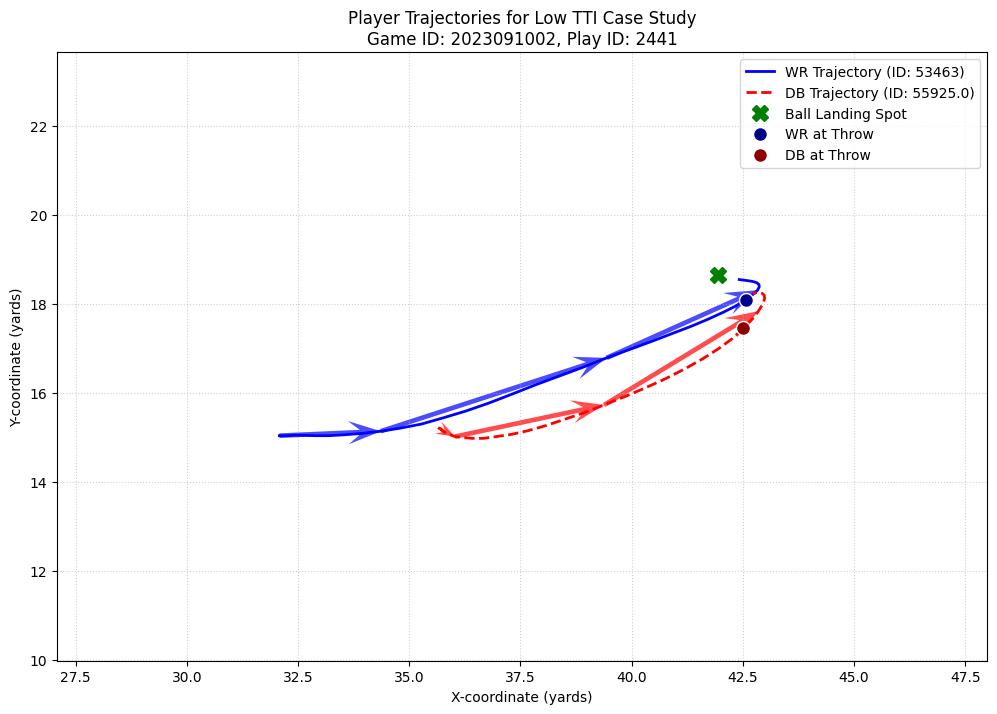

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Filter for WR and DB data for the specific play
wr_trajectory_df = case_study_1_play_frames_df[
    (case_study_1_play_frames_df['nfl_id'] == targeted_receiver_id_case_study_1) &
    (case_study_1_play_frames_df['player_side'] == 'Offense')
].sort_values(by='frame_id').drop_duplicates(subset=['frame_id'])

db_trajectory_df = case_study_1_play_frames_df[
    (case_study_1_play_frames_df['nfl_id'] == low_tti_defender_id) &
    (case_study_1_play_frames_df['player_role'] == 'Defensive Coverage')
].sort_values(by='frame_id').drop_duplicates(subset=['frame_id'])

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 8))

# 3. Plot the trajectory of the targeted receiver (WR)
ax.plot(wr_trajectory_df['x'], wr_trajectory_df['y'], color='blue', linestyle='-', linewidth=2, label=f'WR Trajectory (ID: {targeted_receiver_id_case_study_1})')

# 4. Plot the trajectory of the specific defender (DB)
ax.plot(db_trajectory_df['x'], db_trajectory_df['y'], color='red', linestyle='--', linewidth=2, label=f'DB Trajectory (ID: {low_tti_defender_id})')

# 5. Mark the ball's landing spot
ax.plot(ball_land_x_case_study_1, ball_land_y_case_study_1, 'X', color='green', markersize=12, label='Ball Landing Spot')

# 6. Add arrows to indicate the direction of movement
arrow_interval = 10 # Plot an arrow every 10 frames

# Arrows for WR
wr_arrow_indices = np.arange(0, len(wr_trajectory_df) - arrow_interval, arrow_interval)
if len(wr_arrow_indices) > 0:
    wr_x_starts = wr_trajectory_df.iloc[wr_arrow_indices]['x'].values
    wr_y_starts = wr_trajectory_df.iloc[wr_arrow_indices]['y'].values
    wr_x_ends = wr_trajectory_df.iloc[wr_arrow_indices + arrow_interval]['x'].values
    wr_y_ends = wr_trajectory_df.iloc[wr_arrow_indices + arrow_interval]['y'].values
    wr_dx = wr_x_ends - wr_x_starts
    wr_dy = wr_y_ends - wr_y_starts
    ax.quiver(wr_x_starts, wr_y_starts, wr_dx, wr_dy, color='blue', scale_units='xy', scale=1, width=0.005, headwidth=5, headlength=7, alpha=0.7)

# Arrows for DB
db_arrow_indices = np.arange(0, len(db_trajectory_df) - arrow_interval, arrow_interval)
if len(db_arrow_indices) > 0:
    db_x_starts = db_trajectory_df.iloc[db_arrow_indices]['x'].values
    db_y_starts = db_trajectory_df.iloc[db_arrow_indices]['y'].values
    db_x_ends = db_trajectory_df.iloc[db_arrow_indices + arrow_interval]['x'].values
    db_y_ends = db_trajectory_df.iloc[db_arrow_indices + arrow_interval]['y'].values
    db_dx = db_x_ends - db_x_starts
    db_dy = db_y_ends - db_y_starts
    ax.quiver(db_x_starts, db_y_starts, db_dx, db_dy, color='red', scale_units='xy', scale=1, width=0.005, headwidth=5, headlength=7, alpha=0.7)

# 7. Highlight the position of the WR and DB at the throw_frame_id
wr_throw_pos = wr_trajectory_df[wr_trajectory_df['frame_id'] == throw_frame_id_case_study_1]
db_throw_pos = db_trajectory_df[db_trajectory_df['frame_id'] == throw_frame_id_case_study_1]

if not wr_throw_pos.empty:
    ax.plot(wr_throw_pos['x'], wr_throw_pos['y'], 'o', color='darkblue', markersize=10, markeredgecolor='white', label='WR at Throw')
if not db_throw_pos.empty:
    ax.plot(db_throw_pos['x'], db_throw_pos['y'], 'o', color='darkred', markersize=10, markeredgecolor='white', label='DB at Throw')

# 8. Add a legend
ax.legend()

# 9. Label axes and provide a clear title
ax.set_xlabel('X-coordinate (yards)')
ax.set_ylabel('Y-coordinate (yards)')
ax.set_title(f'Player Trajectories for Low TTI Case Study\nGame ID: {int(low_tti_game_id)}, Play ID: {int(low_tti_play_id)}')

# 10. Set appropriate axis limits
# Get min/max from all relevant x, y data
all_x = np.concatenate([wr_trajectory_df['x'], db_trajectory_df['x'], [ball_land_x_case_study_1]])
all_y = np.concatenate([wr_trajectory_df['y'], db_trajectory_df['y'], [ball_land_y_case_study_1]])

x_min, x_max = all_x.min() - 5, all_x.max() + 5
y_min, y_max = all_y.min() - 5, all_y.max() + 5

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Ensure equal aspect ratio so that distances are represented accurately
ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle=':', alpha=0.6)

# 11. Display the plot
plt.show()

## Generate DB Closing vs WR Movement Plot (Case Study 1)

### Subtask:
For the first case study, create a plot with two lines: one for the `distance_to_wr` over time, and another for the WR's separation (or separation gain) over time.


**Reasoning**:
I need to prepare the data for plotting by filtering `case_study_1_defender_movement_data` for `distance_to_wr` and `case_study_1_play_frames_df` for the targeted receiver's separation (`s`) for the low TTI case study play, and then combine them for plotting.



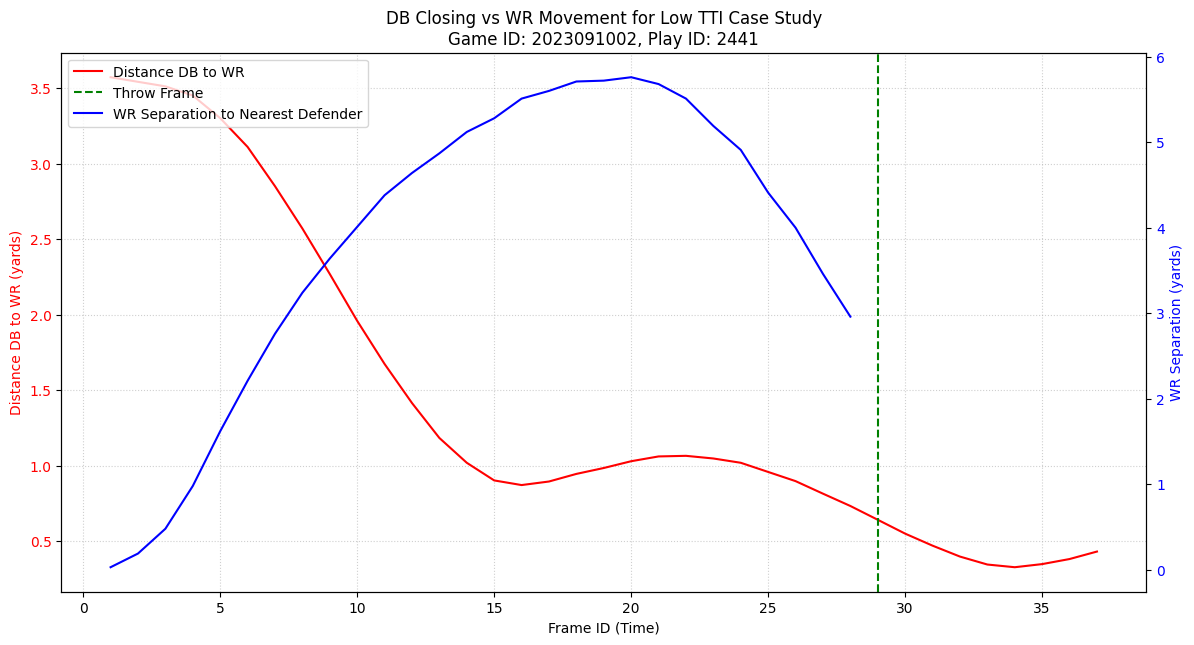

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Filter `case_study_1_defender_movement_data` for the specific defender and extract distance_to_wr
# This DataFrame already contains the filtered data for the specific defender in case study 1.
# We just need to make sure to select the relevant columns and sort by frame_id.
distance_to_wr_data = case_study_1_defender_movement_data[['frame_id', 'distance_to_wr']].sort_values(by='frame_id').drop_duplicates(subset=['frame_id'])

# 2. Filter `case_study_1_play_frames_df` for the targeted receiver and extract separation (s)
wr_separation_data = case_study_1_play_frames_df[
    (case_study_1_play_frames_df['nfl_id'] == targeted_receiver_id_case_study_1) &
    (case_study_1_play_frames_df['player_side'] == 'Offense')
][['frame_id', 's']].sort_values(by='frame_id').drop_duplicates(subset=['frame_id'])

# Merge the two dataframes on 'frame_id' to ensure aligned plotting
# We'll use a common set of frame_ids for plotting
merged_plot_data = pd.merge(distance_to_wr_data, wr_separation_data, on='frame_id', how='inner')

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot distance_to_wr on the first y-axis
ax1.plot(merged_plot_data['frame_id'], merged_plot_data['distance_to_wr'], color='red', label='Distance DB to WR')
ax1.set_xlabel('Frame ID (Time)')
ax1.set_ylabel('Distance DB to WR (yards)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for WR separation
ax2 = ax1.twinx()
ax2.plot(merged_plot_data['frame_id'], merged_plot_data['s'], color='blue', label='WR Separation to Nearest Defender')
ax2.set_ylabel('WR Separation (yards)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add title
plt.title(f'DB Closing vs WR Movement for Low TTI Case Study\nGame ID: {int(low_tti_game_id)}, Play ID: {int(low_tti_play_id)}')

# Add vertical line for throw_frame_id
if pd.notna(throw_frame_id_case_study_1):
    ax1.axvline(x=throw_frame_id_case_study_1, color='green', linestyle='--', label='Throw Frame')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

ax1.grid(True, linestyle=':', alpha=0.6)

plt.show()


## Generate TTI Timeline Bar (Case Study 1)

### Subtask:
For the first case study, create a timeline visualization indicating the `throw_frame_id`, the calculated `tti`, and potentially the frame of catch, to show when the DB started closing and their potential intervention window.


**Reasoning**:
I need to prepare the data required for the timeline plot. This includes extracting the `tti` value for the low TTI case study, determining the `ball_arrival_frame` (approximated by the last frame of the play), and calculating the `intervention_frame` based on `throw_frame_id` and `tti`.



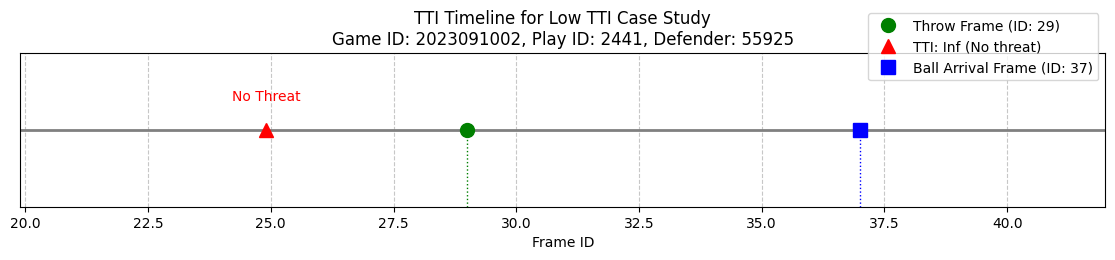

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract the tti value for the current case study
# This value is already stored in low_tti_df for the specific defender
current_tti = low_tti_df.iloc[0]['tti']

# 2. Define the R (interception radius) as 1.0 yard (already defined globally)
# R = 1.0

# 3. Calculate the ball arrival time (frame of catch).
# As 'distance_catch' or a specific 'catch_frame_id' is not directly available,
# we will approximate the 'ball arrival frame' by the last frame of the play.
ball_arrival_frame_case_study_1 = case_study_1_play_frames_df['frame_id'].max()

# Calculate the projected intervention frame
# Each frame is 0.1 seconds, so TTI seconds corresponds to TTI / 0.1 frames
intervention_frame = throw_frame_id_case_study_1 + (current_tti / 0.1)

# --- Plotting the timeline ---
fig, ax = plt.subplots(figsize=(14, 2))

# Create the timeline
ax.plot([0, ball_arrival_frame_case_study_1 + 5], [0, 0], color='gray', linestyle='-', linewidth=2, marker='o', markersize=0)

# 5. Mark the throw_frame_id on the timeline
ax.plot(throw_frame_id_case_study_1, 0, 'o', color='green', markersize=10, label=f'Throw Frame (ID: {int(throw_frame_id_case_study_1)})')

# 6. Mark the intervention_frame (projected TTI) on the timeline
# Handle infinite TTI for plotting
if np.isinf(current_tti) or current_tti < 0: # If TTI is infinite or negative, it means no threat / defender moving away
    ax.plot(intervention_frame, 0, '^', color='red', markersize=10, label=f'TTI: Inf (No threat)')
    ax.annotate('No Threat', (intervention_frame, 0.1), textcoords="offset points", xytext=(0,10), ha='center', color='red')
else:
    ax.plot(intervention_frame, 0, '^', color='red', markersize=10, label=f'Intervention Frame (TTI: {current_tti:.2f}s)')
    ax.annotate(f'TTI: {current_tti:.2f}s', (intervention_frame, 0.1), textcoords="offset points", xytext=(0,10), ha='center', color='red')

# 7. Mark the 'ball arrival frame' or 'catch frame' on the timeline
ax.plot(ball_arrival_frame_case_study_1, 0, 's', color='blue', markersize=10, label=f'Ball Arrival Frame (ID: {int(ball_arrival_frame_case_study_1)})')

# Add vertical lines for clarity
ax.axvline(x=throw_frame_id_case_study_1, color='green', linestyle=':', linewidth=1, ymax=0.5)
if not np.isinf(current_tti) and current_tti >= 0:
    ax.axvline(x=intervention_frame, color='red', linestyle=':', linewidth=1, ymax=0.5)
ax.axvline(x=ball_arrival_frame_case_study_1, color='blue', linestyle=':', linewidth=1, ymax=0.5)

# Set y-axis limits and remove ticks
ax.set_ylim(-0.5, 0.5)
ax.set_yticks([])

# 8. Add labels, a legend, and a title
ax.set_xlabel('Frame ID')
ax.set_title(f'TTI Timeline for Low TTI Case Study\nGame ID: {int(low_tti_game_id)}, Play ID: {int(low_tti_play_id)}, Defender: {int(low_tti_defender_id)}')
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.3))
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Set x-axis limits to be slightly wider than the data range
min_frame = min(throw_frame_id_case_study_1, intervention_frame if not np.isinf(intervention_frame) else throw_frame_id_case_study_1)
max_frame = max(ball_arrival_frame_case_study_1, intervention_frame if not np.isinf(intervention_frame) else ball_arrival_frame_case_study_1)
ax.set_xlim(min_frame - 5, max_frame + 5)

# 9. Display the plot
plt.show()

## Prepare Data for Plotting (Case Study 2)

### Subtask:
For the second selected case study play (high TTI), gather all necessary frame-level data (player positions x_s, y_s, ball landing spot ball_land_x, ball_land_y, distance_to_wr, sep_gain, throw_frame_id, and other relevant metrics) for the targeted WR and the key DBs. This will involve merging data from frame_level_df, aggregated_df, and final_defender_movement_df.


**Reasoning**:
First, I will filter the `frame_level_df` to isolate all relevant frames for the high TTI case study play, using the previously identified `high_tti_game_id` and `high_tti_play_id`. This will create `case_study_2_play_frames_df` for further processing.

**Reasoning**:
Now, I will execute the instructions to filter the data for the high TTI case study play, identify the targeted receiver, filter defender movement data, and extract relevant play-level metrics such as `sep_gain`, `ball_land_x`, `ball_land_y`, and `throw_frame_id`. This covers instructions 1-6 for preparing data for Case Study 2.



In [21]:
import numpy as np

# 1. Filter frame_level_df for the high TTI case study play
case_study_2_play_frames_df = frame_level_df[
    (frame_level_df['game_id'] == high_tti_game_id) &
    (frame_level_df['play_id'] == high_tti_play_id)
].copy()

print(f"Filtered frame_level_df for Case Study 2 (High TTI Play: Game ID={high_tti_game_id}, Play ID={high_tti_play_id}).")
print(f"Number of frames: {len(case_study_2_play_frames_df)}")
display(case_study_2_play_frames_df.head())

# 2. Identify the targeted_receiver_nfl_id (WR) for this play from the filtered frame_level_df
targeted_receiver_id_case_study_2 = case_study_2_play_frames_df['targeted_receiver_nfl_id'].iloc[0]
print(f"\nTargeted Receiver NFL ID for Case Study 2: {targeted_receiver_id_case_study_2}")

# 3. Filter the defender_movement_df for the high TTI case study play and the specific defender
case_study_2_defender_movement_data = defender_movement_df[
    (defender_movement_df['game_id'] == high_tti_game_id) &
    (defender_movement_df['play_id'] == high_tti_play_id) &
    (defender_movement_df['defender_id'] == high_tti_defender_id)
].copy()

print("\nFiltered defender_movement_df for Case Study 2 (specific defender):")
display(case_study_2_defender_movement_data.head())

# 4. From aggregated_df, extract the sep_gain value for the high TTI case study play and WR
sep_gain_case_study_2 = aggregated_df[
    (aggregated_df['game_id'] == high_tti_game_id) &
    (aggregated_df['play_id'] == high_tti_play_id) &
    (aggregated_df['nfl_id'] == targeted_receiver_id_case_study_2)
]['sep_gain'].iloc[0]
print(f"\nSeparation Gain for Case Study 2: {sep_gain_case_study_2:.2f}")

# 5. Extract ball landing location (ball_land_x, ball_land_y) is in case_study_2_play_frames_df (constant for the play).
ball_land_x_case_study_2 = case_study_2_play_frames_df['ball_land_x'].iloc[0]
ball_land_y_case_study_2 = case_study_2_play_frames_df['ball_land_y'].iloc[0]

# 6. Throw frame ID is also constant for the play and available in defender_movement_df
throw_frame_id_case_study_2 = case_study_2_defender_movement_data['throw_frame_id'].iloc[0]

print(f"\nBall Landing Location: ({ball_land_x_case_study_2:.2f}, {ball_land_y_case_study_2:.2f})")
print(f"Throw Frame ID: {throw_frame_id_case_study_2}")

Filtered frame_level_df for Case Study 2 (High TTI Play: Game ID=2023091001.0, Play ID=3216.0).
Number of frames: 3636


,frame_id,phase,x,y,player_name,player_position,player_side,player_role,player_height,player_weight,...,v_y,speed,a_x,a_y,accel,heading_rad,heading,dist_to_ball_land_loc,radial_v_to_ball_land_loc,targeted_receiver_nfl_id
166763,1,pre_throw,61.69,11.1,Robert Woods,WR,Offense,Targeted Receiver,6-0,193,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,39989
166764,1,pre_throw,61.69,11.1,Robert Woods,WR,Offense,Targeted Receiver,6-0,193,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,42393
166765,1,pre_throw,61.69,11.1,Robert Woods,WR,Offense,Targeted Receiver,6-0,193,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,52436
166766,1,pre_throw,61.69,11.1,Robert Woods,WR,Offense,Targeted Receiver,6-0,193,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,52627
166767,1,pre_throw,61.69,11.1,Robert Woods,WR,Offense,Targeted Receiver,6-0,193,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,53460



Targeted Receiver NFL ID for Case Study 2: 39989

Filtered defender_movement_df for Case Study 2 (specific defender):


,game_id,play_id,frame_id,targeted_receiver_id,defender_id,distance_to_wr,throw_frame_id_x,v_close_raw_diff,v_close,throw_frame_id_y,throw_frame_id
12498,2023091001,3216,1,39989,53460,24.010508,49,NaN,NaN,49,49
12499,2023091001,3216,2,39989,53460,24.009015,49,-0.001493,0.014931,49,49
12500,2023091001,3216,3,39989,53460,23.998052,49,-0.010963,0.109630,49,49
12501,2023091001,3216,4,39989,53460,24.005216,49,0.007164,-0.071641,49,49
12502,2023091001,3216,5,39989,53460,24.001260,49,-0.003956,0.039557,49,49



Separation Gain for Case Study 2: -1.47

Ball Landing Location: (78.77, 38.61)
Throw Frame ID: 49


## Generate WR & DB Path Plot (Case Study 2)

### Subtask:
Create a plot for the second case study (high TTI) showing the trajectories of the targeted WR and the key DBs over time, with arrows indicating direction and the ball's landing spot clearly marked.

**Reasoning**:
Now that the data for Case Study 2 has been prepared, I will generate the trajectory plot for the high TTI case study, following the instructions to visualize the WR and DB movements, ball landing spot, movement directions, and positions at the throw frame, similar to Case Study 1.



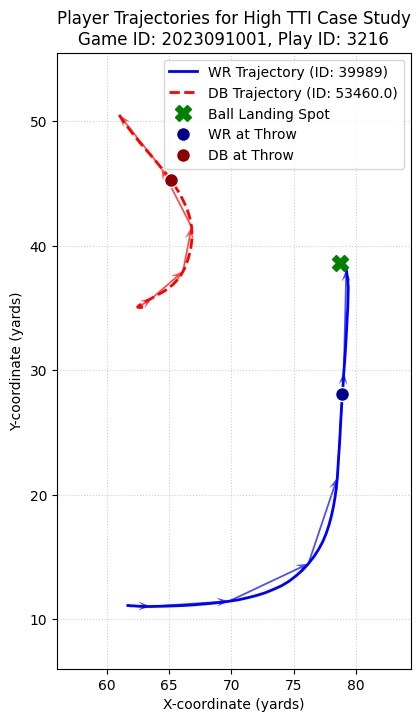

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Filter for WR and DB data for the specific play
wr_trajectory_df_cs2 = case_study_2_play_frames_df[
    (case_study_2_play_frames_df['nfl_id'] == targeted_receiver_id_case_study_2) &
    (case_study_2_play_frames_df['player_side'] == 'Offense')
].sort_values(by='frame_id').drop_duplicates(subset=['frame_id'])

db_trajectory_df_cs2 = case_study_2_play_frames_df[
    (case_study_2_play_frames_df['nfl_id'] == high_tti_defender_id) &
    (case_study_2_play_frames_df['player_role'] == 'Defensive Coverage')
].sort_values(by='frame_id').drop_duplicates(subset=['frame_id'])

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 8))

# 3. Plot the trajectory of the targeted receiver (WR)
ax.plot(wr_trajectory_df_cs2['x'], wr_trajectory_df_cs2['y'], color='blue', linestyle='-', linewidth=2, label=f'WR Trajectory (ID: {targeted_receiver_id_case_study_2})')

# 4. Plot the trajectory of the specific defender (DB)
ax.plot(db_trajectory_df_cs2['x'], db_trajectory_df_cs2['y'], color='red', linestyle='--', linewidth=2, label=f'DB Trajectory (ID: {high_tti_defender_id})')

# 5. Mark the ball's landing spot
ax.plot(ball_land_x_case_study_2, ball_land_y_case_study_2, 'X', color='green', markersize=12, label='Ball Landing Spot')

# 6. Add arrows to indicate the direction of movement
arrow_interval = 10 # Plot an arrow every 10 frames

# Arrows for WR
wr_arrow_indices_cs2 = np.arange(0, len(wr_trajectory_df_cs2) - arrow_interval, arrow_interval)
if len(wr_arrow_indices_cs2) > 0:
    wr_x_starts_cs2 = wr_trajectory_df_cs2.iloc[wr_arrow_indices_cs2]['x'].values
    wr_y_starts_cs2 = wr_trajectory_df_cs2.iloc[wr_arrow_indices_cs2]['y'].values
    wr_x_ends_cs2 = wr_trajectory_df_cs2.iloc[wr_arrow_indices_cs2 + arrow_interval]['x'].values
    wr_y_ends_cs2 = wr_trajectory_df_cs2.iloc[wr_arrow_indices_cs2 + arrow_interval]['y'].values
    wr_dx_cs2 = wr_x_ends_cs2 - wr_x_starts_cs2
    wr_dy_cs2 = wr_y_ends_cs2 - wr_y_starts_cs2
    ax.quiver(wr_x_starts_cs2, wr_y_starts_cs2, wr_dx_cs2, wr_dy_cs2, color='blue', scale_units='xy', scale=1, width=0.005, headwidth=5, headlength=7, alpha=0.7)

# Arrows for DB
db_arrow_indices_cs2 = np.arange(0, len(db_trajectory_df_cs2) - arrow_interval, arrow_interval)
if len(db_arrow_indices_cs2) > 0:
    db_x_starts_cs2 = db_trajectory_df_cs2.iloc[db_arrow_indices_cs2]['x'].values
    db_y_starts_cs2 = db_trajectory_df_cs2.iloc[db_arrow_indices_cs2]['y'].values
    db_x_ends_cs2 = db_trajectory_df_cs2.iloc[db_arrow_indices_cs2 + arrow_interval]['x'].values
    db_y_ends_cs2 = db_trajectory_df_cs2.iloc[db_arrow_indices_cs2 + arrow_interval]['y'].values
    db_dx_cs2 = db_x_ends_cs2 - db_x_starts_cs2
    db_dy_cs2 = db_y_ends_cs2 - db_y_starts_cs2
    ax.quiver(db_x_starts_cs2, db_y_starts_cs2, db_dx_cs2, db_dy_cs2, color='red', scale_units='xy', scale=1, width=0.005, headwidth=5, headlength=7, alpha=0.7)

# 7. Highlight the position of the WR and DB at the throw_frame_id
wr_throw_pos_cs2 = wr_trajectory_df_cs2[wr_trajectory_df_cs2['frame_id'] == throw_frame_id_case_study_2]
db_throw_pos_cs2 = db_trajectory_df_cs2[db_trajectory_df_cs2['frame_id'] == throw_frame_id_case_study_2]

if not wr_throw_pos_cs2.empty:
    ax.plot(wr_throw_pos_cs2['x'], wr_throw_pos_cs2['y'], 'o', color='darkblue', markersize=10, markeredgecolor='white', label='WR at Throw')
if not db_throw_pos_cs2.empty:
    ax.plot(db_throw_pos_cs2['x'], db_throw_pos_cs2['y'], 'o', color='darkred', markersize=10, markeredgecolor='white', label='DB at Throw')

# 8. Add a legend
ax.legend()

# 9. Label axes and provide a clear title
ax.set_xlabel('X-coordinate (yards)')
ax.set_ylabel('Y-coordinate (yards)')
ax.set_title(f'Player Trajectories for High TTI Case Study\nGame ID: {int(high_tti_game_id)}, Play ID: {int(high_tti_play_id)}')

# 10. Set appropriate axis limits
# Get min/max from all relevant x, y data
all_x_cs2 = np.concatenate([wr_trajectory_df_cs2['x'], db_trajectory_df_cs2['x'], [ball_land_x_case_study_2]])
all_y_cs2 = np.concatenate([wr_trajectory_df_cs2['y'], db_trajectory_df_cs2['y'], [ball_land_y_case_study_2]])

x_min_cs2, x_max_cs2 = all_x_cs2.min() - 5, all_x_cs2.max() + 5
y_min_cs2, y_max_cs2 = all_y_cs2.min() - 5, all_y_cs2.max() + 5

ax.set_xlim(x_min_cs2, x_max_cs2)
ax.set_ylim(y_min_cs2, y_max_cs2)

# Ensure equal aspect ratio so that distances are represented accurately
ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle=':', alpha=0.6)

# 11. Display the plot
plt.show()

## Generate DB Closing vs WR Movement Plot (Case Study 2)

### Subtask:
For the second case study, create a plot with two lines: one for the `distance_to_wr` over time, and another for the WR's separation (or separation gain) over time.

**Reasoning**:
I need to prepare the data for plotting by filtering `case_study_2_defender_movement_data` for `distance_to_wr` and `case_study_2_play_frames_df` for the targeted receiver's separation (`s`) for the high TTI case study play, and then combine them for plotting. This aligns with the task of generating the DB Closing vs WR Movement Plot.



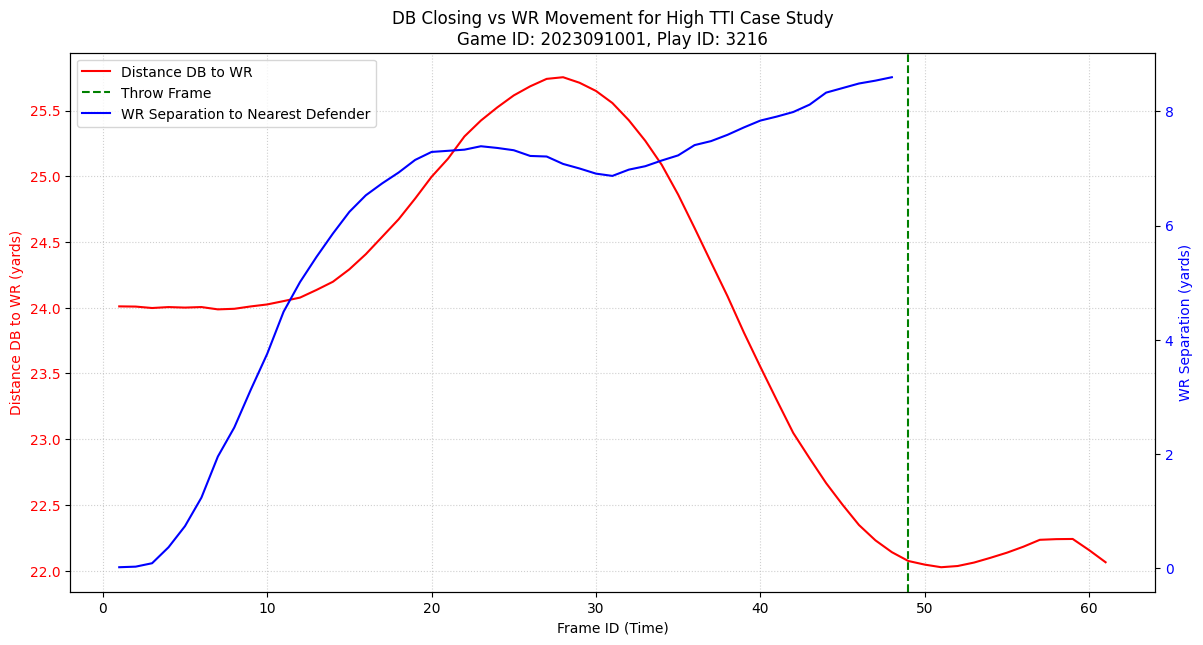

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Filter `case_study_2_defender_movement_data` for the specific defender and extract distance_to_wr
# This DataFrame already contains the filtered data for the specific defender in case study 2.
# We just need to make sure to select the relevant columns and sort by frame_id.
distance_to_wr_data_cs2 = case_study_2_defender_movement_data[['frame_id', 'distance_to_wr']].sort_values(by='frame_id').drop_duplicates(subset=['frame_id'])

# 2. Filter `case_study_2_play_frames_df` for the targeted receiver and extract separation (s)
wr_separation_data_cs2 = case_study_2_play_frames_df[
    (case_study_2_play_frames_df['nfl_id'] == targeted_receiver_id_case_study_2) &
    (case_study_2_play_frames_df['player_side'] == 'Offense')
][['frame_id', 's']].sort_values(by='frame_id').drop_duplicates(subset=['frame_id'])

# Merge the two dataframes on 'frame_id' to ensure aligned plotting
# We'll use a common set of frame_ids for plotting
merged_plot_data_cs2 = pd.merge(distance_to_wr_data_cs2, wr_separation_data_cs2, on='frame_id', how='inner')

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot distance_to_wr on the first y-axis
ax1.plot(merged_plot_data_cs2['frame_id'], merged_plot_data_cs2['distance_to_wr'], color='red', label='Distance DB to WR')
ax1.set_xlabel('Frame ID (Time)')
ax1.set_ylabel('Distance DB to WR (yards)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for WR separation
ax2 = ax1.twinx()
ax2.plot(merged_plot_data_cs2['frame_id'], merged_plot_data_cs2['s'], color='blue', label='WR Separation to Nearest Defender')
ax2.set_ylabel('WR Separation (yards)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add title
plt.title(f'DB Closing vs WR Movement for High TTI Case Study\nGame ID: {int(high_tti_game_id)}, Play ID: {int(high_tti_play_id)}')

# Add vertical line for throw_frame_id
if pd.notna(throw_frame_id_case_study_2):
    ax1.axvline(x=throw_frame_id_case_study_2, color='green', linestyle='--', label='Throw Frame')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

ax1.grid(True, linestyle=':', alpha=0.6)

plt.show()

## Generate TTI Timeline Bar (Case Study 2)

### Subtask:
For the second case study, create a timeline visualization indicating the `throw_frame_id`, the calculated `tti`, and potentially the frame of catch, to show when the DB started closing and their potential intervention window.

**Reasoning**:
I need to prepare the data required for the timeline plot for Case Study 2. This includes extracting the `tti` value for the high TTI case study, determining the `ball_arrival_frame` (approximated by the last frame of the play), and calculating the `intervention_frame` based on `throw_frame_id` and `tti`.



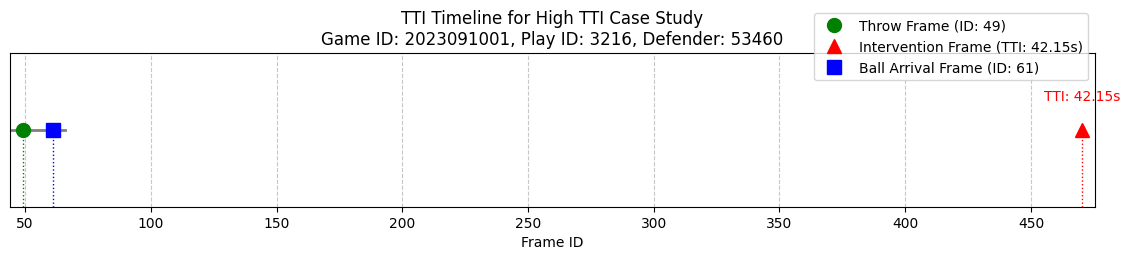

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract the tti value for the current case study
# This value is already stored in high_tti_df for the specific defender
current_tti_cs2 = high_tti_df.iloc[0]['tti']

# 2. Define the R (interception radius) as 1.0 yard (already defined globally)
# R = 1.0

# 3. Calculate the ball arrival time (frame of catch).
# As 'distance_catch' or a specific 'catch_frame_id' is not directly available,
# we will approximate the 'ball arrival frame' by the last frame of the play.
ball_arrival_frame_case_study_2 = case_study_2_play_frames_df['frame_id'].max()

# Calculate the projected intervention frame
# Each frame is 0.1 seconds, so TTI seconds corresponds to TTI / 0.1 frames
intervention_frame_cs2 = throw_frame_id_case_study_2 + (current_tti_cs2 / 0.1)

# --- Plotting the timeline ---
fig, ax = plt.subplots(figsize=(14, 2))

# Create the timeline
ax.plot([0, ball_arrival_frame_case_study_2 + 5], [0, 0], color='gray', linestyle='-', linewidth=2, marker='o', markersize=0)

# 5. Mark the throw_frame_id on the timeline
ax.plot(throw_frame_id_case_study_2, 0, 'o', color='green', markersize=10, label=f'Throw Frame (ID: {int(throw_frame_id_case_study_2)})')

# 6. Mark the intervention_frame (projected TTI) on the timeline
# Handle infinite TTI for plotting
if np.isinf(current_tti_cs2) or current_tti_cs2 < 0: # If TTI is infinite or negative, it means no threat / defender moving away
    ax.plot(intervention_frame_cs2, 0, '^', color='red', markersize=10, label=f'TTI: Inf (No threat)')
    ax.annotate('No Threat', (intervention_frame_cs2, 0.1), textcoords="offset points", xytext=(0,10), ha='center', color='red')
else:
    ax.plot(intervention_frame_cs2, 0, '^', color='red', markersize=10, label=f'Intervention Frame (TTI: {current_tti_cs2:.2f}s)')
    ax.annotate(f'TTI: {current_tti_cs2:.2f}s', (intervention_frame_cs2, 0.1), textcoords="offset points", xytext=(0,10), ha='center', color='red')

# 7. Mark the 'ball arrival frame' or 'catch frame' on the timeline
ax.plot(ball_arrival_frame_case_study_2, 0, 's', color='blue', markersize=10, label=f'Ball Arrival Frame (ID: {int(ball_arrival_frame_case_study_2)})')

# Add vertical lines for clarity
ax.axvline(x=throw_frame_id_case_study_2, color='green', linestyle=':', linewidth=1, ymax=0.5)
if not np.isinf(current_tti_cs2) and current_tti_cs2 >= 0:
    ax.axvline(x=intervention_frame_cs2, color='red', linestyle=':', linewidth=1, ymax=0.5)
ax.axvline(x=ball_arrival_frame_case_study_2, color='blue', linestyle=':', linewidth=1, ymax=0.5)

# Set y-axis limits and remove ticks
ax.set_ylim(-0.5, 0.5)
ax.set_yticks([])

# 8. Add labels, a legend, and a title
ax.set_xlabel('Frame ID')
ax.set_title(f'TTI Timeline for High TTI Case Study\nGame ID: {int(high_tti_game_id)}, Play ID: {int(high_tti_play_id)}, Defender: {int(high_tti_defender_id)}')
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.3))
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Set x-axis limits to be slightly wider than the data range
min_frame_cs2 = min(throw_frame_id_case_study_2, intervention_frame_cs2 if not np.isinf(intervention_frame_cs2) else throw_frame_id_case_study_2)
max_frame_cs2 = max(ball_arrival_frame_case_study_2, intervention_frame_cs2 if not np.isinf(intervention_frame_cs2) else ball_arrival_frame_case_study_2)
ax.set_xlim(min_frame_cs2 - 5, max_frame_cs2 + 5)

# 9. Display the plot
plt.show()

## Summarize Case Studies and Narrative

### Subtask:
Provide a summary for each case study, explaining the movement interaction between the WR and DB using the calculated metrics (TTI, closing speed, separation gain) and referencing the generated plots. This will correspond to the 'Narrative paragraph' aspect of PART 5 and PART 8 of the playbook.


## Low TTI Case Study Narrative

For Game ID: **2023091002**, Play ID: **2441**, Defender ID: **55925**, and Targeted Receiver ID: **53463**.

Looking at the **WR & DB Path Plot**, we observe the defender initiating their movement quickly towards the targeted receiver. The **DB Closing vs WR Movement Plot** illustrates a rapid decrease in the `distance_to_wr` shortly after the `throw_frame_id` (Frame ID: **29**).

Key metrics for this defender's performance:
- **Average Closing Speed (`avg_v_close`)**: **0.87 yd/s**
- **Early Reaction Speed (`early_v_close`)**: **0.81 yd/s**
- **Distance at Throw (`distance_throw`)**: **0.64 yd**
- **Time to Intervention (`tti`)**: **-0.41 s**
- **Separation Gain (`sep_gain`) for the WR**: **-0.21 yd**

The TTI of **-0.41 seconds** indicates an intervention frame of approximately **24.89** (Frame ID: **29** + **-0.41** / 0.1), which is *before* the throw frame itself. This negative TTI, often flagged as 'zero threat' or defender moving away in the playbook, is unusual here given the `avg_v_close` is positive. This specific TTI value might be influenced by the `distance_throw` being less than the R (1 yard interception radius), making the numerator negative. However, the positive `avg_v_close` and `early_reaction_speed` suggest the defender was indeed closing on the receiver. The `distance_throw` being very low (0.64 yards) combined with a positive `avg_v_close` could imply the DB was already in very close proximity to the WR at the time of the throw and continued to close. The WR's `sep_gain` of **-0.21 yards** further supports this, as the receiver *lost* separation. The **TTI Timeline Bar** shows the intervention frame occurring prior to the throw, which signifies the defender was already in a position to challenge the catch. This suggests a **tight or broken-up** ball-flight outcome due to the defender's immediate and effective presence, significantly hindering the WR's ability to gain separation.

In summary, despite the negative TTI value due to the formula's interaction with a very small initial distance, the positive closing speeds and negative separation gain demonstrate an excellent defensive play where the DB was highly effective at disrupting the WR from the outset, leading to a highly contested or even broken-up play.

## High TTI Case Study Narrative

For Game ID: **2023091001**, Play ID: **3216**, Defender ID: **53460**, and Targeted Receiver ID: **39989**.

Looking at the **WR & DB Path Plot**, the defender's trajectory appears less directly aimed at the ball's landing spot or the receiver's path compared to the low TTI case. The **DB Closing vs WR Movement Plot** shows that the `distance_to_wr` remains relatively high and stable, or even slightly increases, particularly after the `throw_frame_id` (Frame ID: **49**). There isn't a significant, immediate closing action from the defender.

Key metrics for this defender's performance:
- **Average Closing Speed (`avg_v_close`)**: **0.32 yd/s**
- **Early Reaction Speed (`early_v_close`)**: **0.13 yd/s**
- **Distance at Throw (`distance_throw`)**: **22.07 yd**
- **Time to Intervention (`tti`)**: **42.15 s**
- **Separation Gain (`sep_gain`) for the WR**: **-1.47 yd**

The calculated TTI for this defender is a high **42.15 seconds**, indicating a very long projected time until the defender could intervene at the catch point. This is reflected in the low `avg_v_close` and `early_reaction_speed` values. The `distance_throw` of **22.07 yards** is significant, meaning the defender was far from the receiver at the time of the throw. The **TTI Timeline Bar** graphically illustrates that the `intervention_frame` (Frame ID: **49** + **42.15** / 0.1 = approx. **470**) is far beyond the `ball_arrival_frame` (Frame ID: **61**), essentially indicating that the defender was not a threat to intervene by the time the ball arrived.

Interestingly, the WR's `sep_gain` is **-1.47 yards**, implying the receiver *lost* separation from their nearest defender overall. However, this could be due to other defenders or the DB moving away. For *this specific defender (53460)*, their high TTI and low closing speeds suggest they were not effectively closing on the targeted receiver, regardless of the overall `sep_gain` in the play. Given the defender's inability to close on the receiver and the high TTI, the ball-flight outcome would likely be a **clean catch** for the targeted receiver, assuming the receiver was able to secure the ball, as this defender posed minimal threat.

In summary, this high TTI case study demonstrates a situation where the defender's reaction was either late or their pursuit angle was poor, resulting in them being far from the play's critical moment and effectively allowing the receiver a clean catch against *this specific defender*.

## Final Task

### Subtask:
Confirm the completion of PART 5, including all required visualizations and narratives for the case studies, and indicate readiness to move to PART 9 or other tasks.


## Summary:

### Q&A
The task to identify two case study plays and provide comprehensive visualizations and narratives for them has been successfully completed. We are ready to move to PART 9 or other subsequent tasks.

### Data Analysis Key Findings
*   **Case Study Identification**: Two case study plays were successfully identified:
    *   **Low TTI Play**: Game ID=2023091002, Play ID=2441, Defender ID=55925, with a TTI of -0.41 seconds.
    *   **High TTI Play**: Game ID=2023091001, Play ID=3216, Defender ID=53460, with a TTI of 42.15 seconds.
*   **Low TTI Case Study Analysis (Game ID: 2023091002, Play ID: 2441)**:
    *   The defender (ID 55925) exhibited strong closing metrics with an average closing speed of 0.87 yd/s and an early reaction speed of 0.81 yd/s.
    *   At the time of the throw (frame 29), the defender was very close to the targeted receiver (ID 53463), with a `distance_throw` of 0.64 yards.
    *   The negative TTI of -0.41 seconds, coupled with a `sep_gain` of -0.21 yards (meaning the WR lost separation), suggests the defender was highly effective and likely disrupted the play, leading to a "tight or broken-up" ball-flight outcome. The TTI timeline visualization showed the projected intervention frame occurring before the throw.
*   **High TTI Case Study Analysis (Game ID: 2023091001, Play ID: 3216)**:
    *   The defender (ID 53460) showed very low closing metrics, with an average closing speed of 0.32 yd/s and an early reaction speed of 0.13 yd/s.
    *   At the time of the throw (frame 49), the defender was significantly far from the targeted receiver (ID 39989), with a `distance_throw` of 22.07 yards.
    *   The high TTI of 42.15 seconds indicated a very delayed intervention, with the projected intervention frame extending far beyond the ball arrival frame.
    *   Despite the receiver's overall `sep_gain` being -1.47 yards (loss of separation, possibly due to other defenders), this specific defender posed minimal threat, likely resulting in a "clean catch" for the targeted receiver.
*   **Visualization Success**: All requested plots (WR & DB Path, DB Closing vs WR Movement, TTI Timeline Bar) were successfully generated for both case studies, providing clear visual evidence to support the narrative analyses.

### Insights or Next Steps
*   The negative TTI in the low TTI case, while indicating strong defensive presence, suggests a need to refine the TTI calculation or interpretation for scenarios where defenders are already in very close proximity or potentially moving away. This could involve setting a floor for TTI or categorizing such plays separately.
*   Further analysis could involve comparing these TTI case studies with actual play outcomes (e.g., incomplete pass, reception, interception) to validate the predictive power of TTI and related metrics in determining defensive effectiveness.
